In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:

# --------------------------
# Simulation of Futures Price
# --------------------------
def simulate_futures(S0, mu, sigma, T, dt):
    """
    Simulate a futures price path using geometric Brownian motion.
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    dW = np.random.standard_normal(size=n_steps) * np.sqrt(dt)
    W = np.cumsum(dW)
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)
    return t, S


In [3]:

# --------------------------
# Vectorized Black Model for Options on Futures
# --------------------------
def black_model_option(F, K, T, sigma, r, option_type='call'):
    """
    Price an option on a futures contract using a vectorized Black model.
    
    For T <= 0, the function returns the intrinsic value.
    """
    F = np.asarray(F)
    T = np.asarray(T)
    # Calculate intrinsic values (for T <= 0)
    intrinsic = np.where(option_type == 'call', np.maximum(0, F - K), np.maximum(0, K - F))
    
    # Identify indices with T > 0
    valid = T > 0
    price = intrinsic.copy()
    
    if np.any(valid):
        d1 = np.zeros_like(F)
        d2 = np.zeros_like(F)
        d1[valid] = (np.log(F[valid] / K) + 0.5 * sigma**2 * T[valid]) / (sigma * np.sqrt(T[valid]))
        d2[valid] = d1[valid] - sigma * np.sqrt(T[valid])
        if option_type == 'call':
            price[valid] = np.exp(-r * T[valid]) * (F[valid] * norm.cdf(d1[valid]) - K * norm.cdf(d2[valid]))
        else:
            price[valid] = np.exp(-r * T[valid]) * (K * norm.cdf(-d2[valid]) - F[valid] * norm.cdf(-d1[valid]))
    
    return price


In [4]:

# --------------------------
# Simulate Market Option Price (with noise/mispricing)
# --------------------------
def simulate_market_option_price(theoretical_price, noise_std=0.02):
    """
    Simulate a market option price by adding proportional noise.
    """
    noise = np.random.normal(0, noise_std, size=np.shape(theoretical_price))
    return theoretical_price * (1 + noise)


In [5]:

# --------------------------
# Vectorized Trading Signal Generation
# --------------------------
def generate_trading_signals(theoretical_price, market_price, threshold=0.05):
    """
    Generate trading signals based on mispricing in a vectorized manner.
    
    Signals:
      - "Buy" if market price is significantly below theoretical price.
      - "Sell" if market price is significantly above theoretical price.
      - "Hold" otherwise.
    """
    diff = (theoretical_price - market_price) / theoretical_price
    signals = np.where(diff > threshold, "Buy", np.where(diff < -threshold, "Sell", "Hold"))
    return signals.tolist()


In [6]:

# --------------------------
# Placeholder for Trade Execution
# --------------------------
def execute_trade(signal, current_price):
    """
    Placeholder function to execute a trade.
    
    In a deployable system, this would integrate with a trading API.
    """
    if signal in ["Buy", "Sell"]:
        print(f"Executing {signal} order at price {current_price:.2f}")
    else:
        print("Holding position.")


Final trading signal: Hold
Holding position.


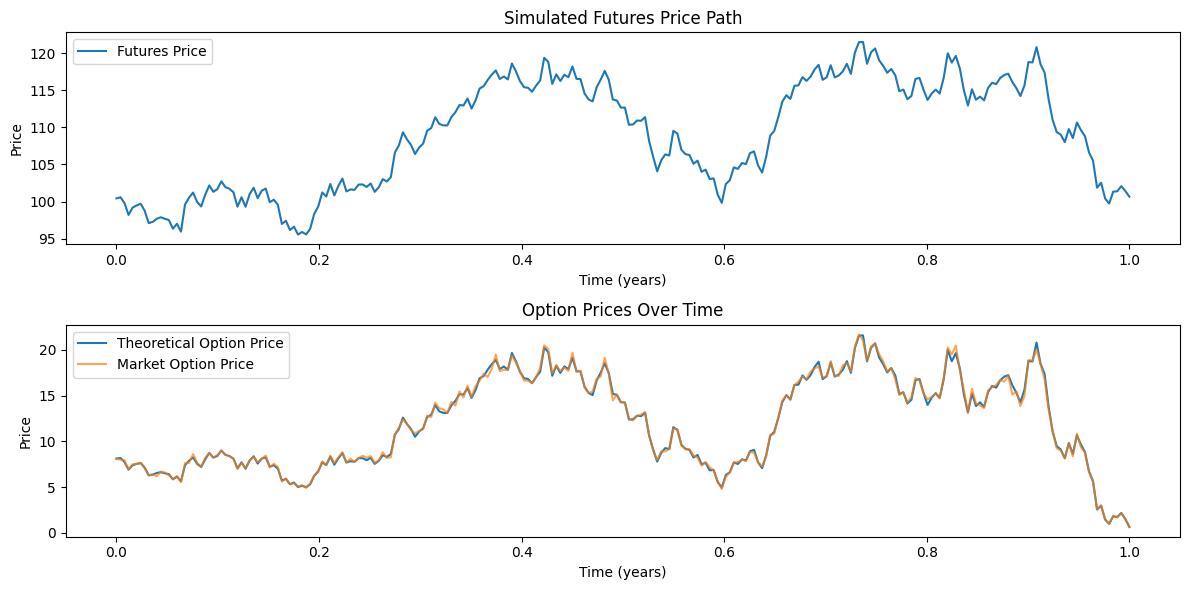

In [7]:

# --------------------------
# Main Simulation and Trading (Vectorized)
# --------------------------
def main():
    # Parameters
    S0 = 100.0            # Initial futures price
    mu = 0.05             # Drift (annualized)
    sigma = 0.2           # Volatility (annualized)
    r = 0.01              # Risk-free rate (annualized)
    T = 1.0               # Time horizon in years (option expiration)
    dt = 1/252            # Daily steps (assuming 252 trading days per year)
    strike = 100.0        # Option strike price
    
    # Simulate futures price path
    t, futures_prices = simulate_futures(S0, mu, sigma, T, dt)
    
    # Compute remaining time to expiration vectorized
    T_rem = T - t
    
    # Compute theoretical option prices over the entire path
    theoretical_prices = black_model_option(futures_prices, strike, T_rem, sigma, r, option_type='call')
    
    # Simulate market option prices with noise
    market_prices = simulate_market_option_price(theoretical_prices)
    
    # Generate trading signals vectorized
    signals = generate_trading_signals(theoretical_prices, market_prices)
    
    # For demonstration, execute a trade based on the final trading signal.
    print("Final trading signal:", signals[-1])
    execute_trade(signals[-1], futures_prices[-1])
    
    # Plot the simulated futures prices and option prices over time.
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(t, futures_prices, label="Futures Price")
    plt.title("Simulated Futures Price Path")
    plt.xlabel("Time (years)")
    plt.ylabel("Price")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(t, theoretical_prices, label="Theoretical Option Price")
    plt.plot(t, market_prices, label="Market Option Price", alpha=0.7)
    plt.title("Option Prices Over Time")
    plt.xlabel("Time (years)")
    plt.ylabel("Price")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
